## Exploratory Data Analysis of Lake George Data

### EDA goals (what we want to learn before modeling)

For Sharp-style NPQ modeling, EDA should answer:

1. Do we have the expected diel NPQ signature?
    * Fluorescence depressed at surface during high light
    * Recovery at night

2. Is fluorescence–Chl bias related to light and depth as expected?
    * Larger bias at shallow depths
    * Larger bias at high radiation

3. Is Secchi behaving sensibly as a proxy for attenuation?
    * Does deterministic PAR decay reasonably with depth?
    * Are there pathological cases (very shallow Secchi, missing values)?

4. Are units and magnitudes sane?
    * PAR_z range
    * Depth attenuation scale
    * Fluorescence vs lab Chl scaling

For the modeling to come, this directly informs:
    * prior scales
    * whether deterministic PAR is even plausible
    * whether hierarchical structure will be needed

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

from graphviz import Digraph
import seaborn as sb

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# SET PATHS
PROJECT_PATH = Path.cwd().parent
DATA_PATH = PROJECT_PATH / 'data'
RAW_DATA_PATH = DATA_PATH / 'raw'
PROCESSED_DATA_PATH = DATA_PATH / 'processed'
assert DATA_PATH.exists(), f"Data path {DATA_PATH} does not exist!"
lake_george_path = RAW_DATA_PATH / "NPQ_Data_EDI.csv"
lake_george_df = pd.read_csv(lake_george_path)

In [3]:
lake_george_df.head().T

0                 1  \
Site                              VP_AnthonysNose   VP_AnthonysNose   
Datetime                         2017-06-02 18:05  2017-06-02 18:07   
Fchl                                     0.898416          0.695232   
Depth                                        3.75              4.79   
DO_sat                                     118.16            118.11   
Surface_total_radiation                667.266667        653.522222   
Surface_total_radiation_1hr_avg        537.683333        548.214141   
Water_tenp                                  14.17             14.11   
Solar_azimuth                          279.013374        279.332128   
Month                                           6                 6   
Subsurface_total_radiation             234.861082         172.18866   
Fchl_Reference                           1.059984          1.006128   

                                                2                 3  \
Site                              VP_AnthonysNose   VP_AnthonysNose   
Datetime                         2017-06-02 18:08  2017-06-02 18:09   
Fchl                                     0.727056          0.944928   
Depth                                        5.81              6.96   
DO_sat                                     118.11            118.14   
Surface_total_radiation                639.777778        626.033333   
Surface_total_radiation_1hr_avg        555.844444         561.24359   
Water_tenp                                  13.98              13.8   
Solar_azimuth                          279.491346        279.650462   
Month                                           6                 6   
Subsurface_total_radiation             126.889154         90.141139   
Fchl_Reference                           1.026936          1.025712   

                                                4  
Site                              VP_AnthonysNose  
Datetime                         2017-06-02 18:12  
Fchl                                     1.108944  
Depth                                        8.97  
DO_sat                                     118.35  
Surface_total_radiation                598.544444  
Surface_total_radiation_1hr_avg        566.328571  
Water_tenp                                   13.7  
Solar_azimuth                          280.127239  
Month                                           6  
Subsurface_total_radiation              49.243875  
Fchl_Reference                            1.08936

In [4]:
lake_george_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50695 entries, 0 to 50694
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Site                             50695 non-null  object 
 1   Datetime                         50695 non-null  object 
 2   Fchl                             50695 non-null  float64
 3   Depth                            50695 non-null  float64
 4   DO_sat                           50695 non-null  float64
 5   Surface_total_radiation          50695 non-null  float64
 6   Surface_total_radiation_1hr_avg  50695 non-null  float64
 7   Water_tenp                       50695 non-null  float64
 8   Solar_azimuth                    50695 non-null  float64
 9   Month                            50695 non-null  int64  
 10  Subsurface_total_radiation       50695 non-null  float64
 11  Fchl_Reference                   50695 non-null  float64
dtypes: float64(9), int

Quick cleanup and preprocessing

In [5]:
lake_george_df=lake_george_df.rename(
    columns=dict(Water_tenp='water_temp')
    ).rename(columns={k:k.lower() for k in lake_george_df.columns})
lake_george_df['datetime'] = pd.to_datetime(lake_george_df.datetime)


In [6]:
lake_george_df.site.value_counts()

site
VP_TeaIsland       33218
VP_AnthonysNose    17477
Name: count, dtype: int64

In [7]:
lake_george_df.month.value_counts().sort_index()

month
5      5362
6     16886
7      9057
8      7362
9      6955
10     3543
11     1318
12      212
Name: count, dtype: int64

In [8]:
lake_george_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50695 entries, 0 to 50694
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   site                             50695 non-null  object        
 1   datetime                         50695 non-null  datetime64[ns]
 2   fchl                             50695 non-null  float64       
 3   depth                            50695 non-null  float64       
 4   do_sat                           50695 non-null  float64       
 5   surface_total_radiation          50695 non-null  float64       
 6   surface_total_radiation_1hr_avg  50695 non-null  float64       
 7   water_temp                       50695 non-null  float64       
 8   solar_azimuth                    50695 non-null  float64       
 9   month                            50695 non-null  int64         
 10  subsurface_total_radiation       50695 non-null  float64  

Is there:
* Suppressed surface fluorescence during daytime
* Recovery at night
* Much weaker diel signal at depth

In [22]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=lake_george_df["datetime"],
        y=lake_george_df["depth"],
        mode="markers",
        marker=dict(
            size=3,
            color=lake_george_df["fchl"],
            colorscale="Viridis",
            colorbar=dict(title="Fchl (RFU)"),
            opacity=0.6
        ),
        name="Fchl_dist"
    )
)

fig.update_layout(
    title="Fluorescence vs Time and Depth",
    xaxis_title="Time",
    yaxis_title="Depth (m)"
)

fig.show()


Does 
* surface suppression dominate
* subsurface maxima exist (important for Sharp’s motivation)


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=lake_george_df["fchl"],
        y=lake_george_df["depth"],
        mode="markers",
        marker=dict(size=3, opacity=0.6),
    )
)

fig.update_layout(
    title="Fluorescence vs Depth",
    xaxis_title="Fchl (RFU)",
    yaxis_title="Depth (m)",
    yaxis_autorange="reversed"
)

fig.show()


Light vs Depth Physics - check for red flags including:
* Light increasing with depth
* Vertical banding unrelated to depth (bad interpolation)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=lake_george_df["subsurface_total_radiation"],
        y=lake_george_df["depth"],
        mode="markers",
        marker=dict(size=3, opacity=0.6),
    )
)

fig.update_layout(
    title="Deterministic Subsurface Light vs Depth",
    xaxis_title="Subsurface total radiation (W m⁻²)",
    yaxis_title="Depth (m)",
    yaxis_autorange="reversed"
)

fig.show()


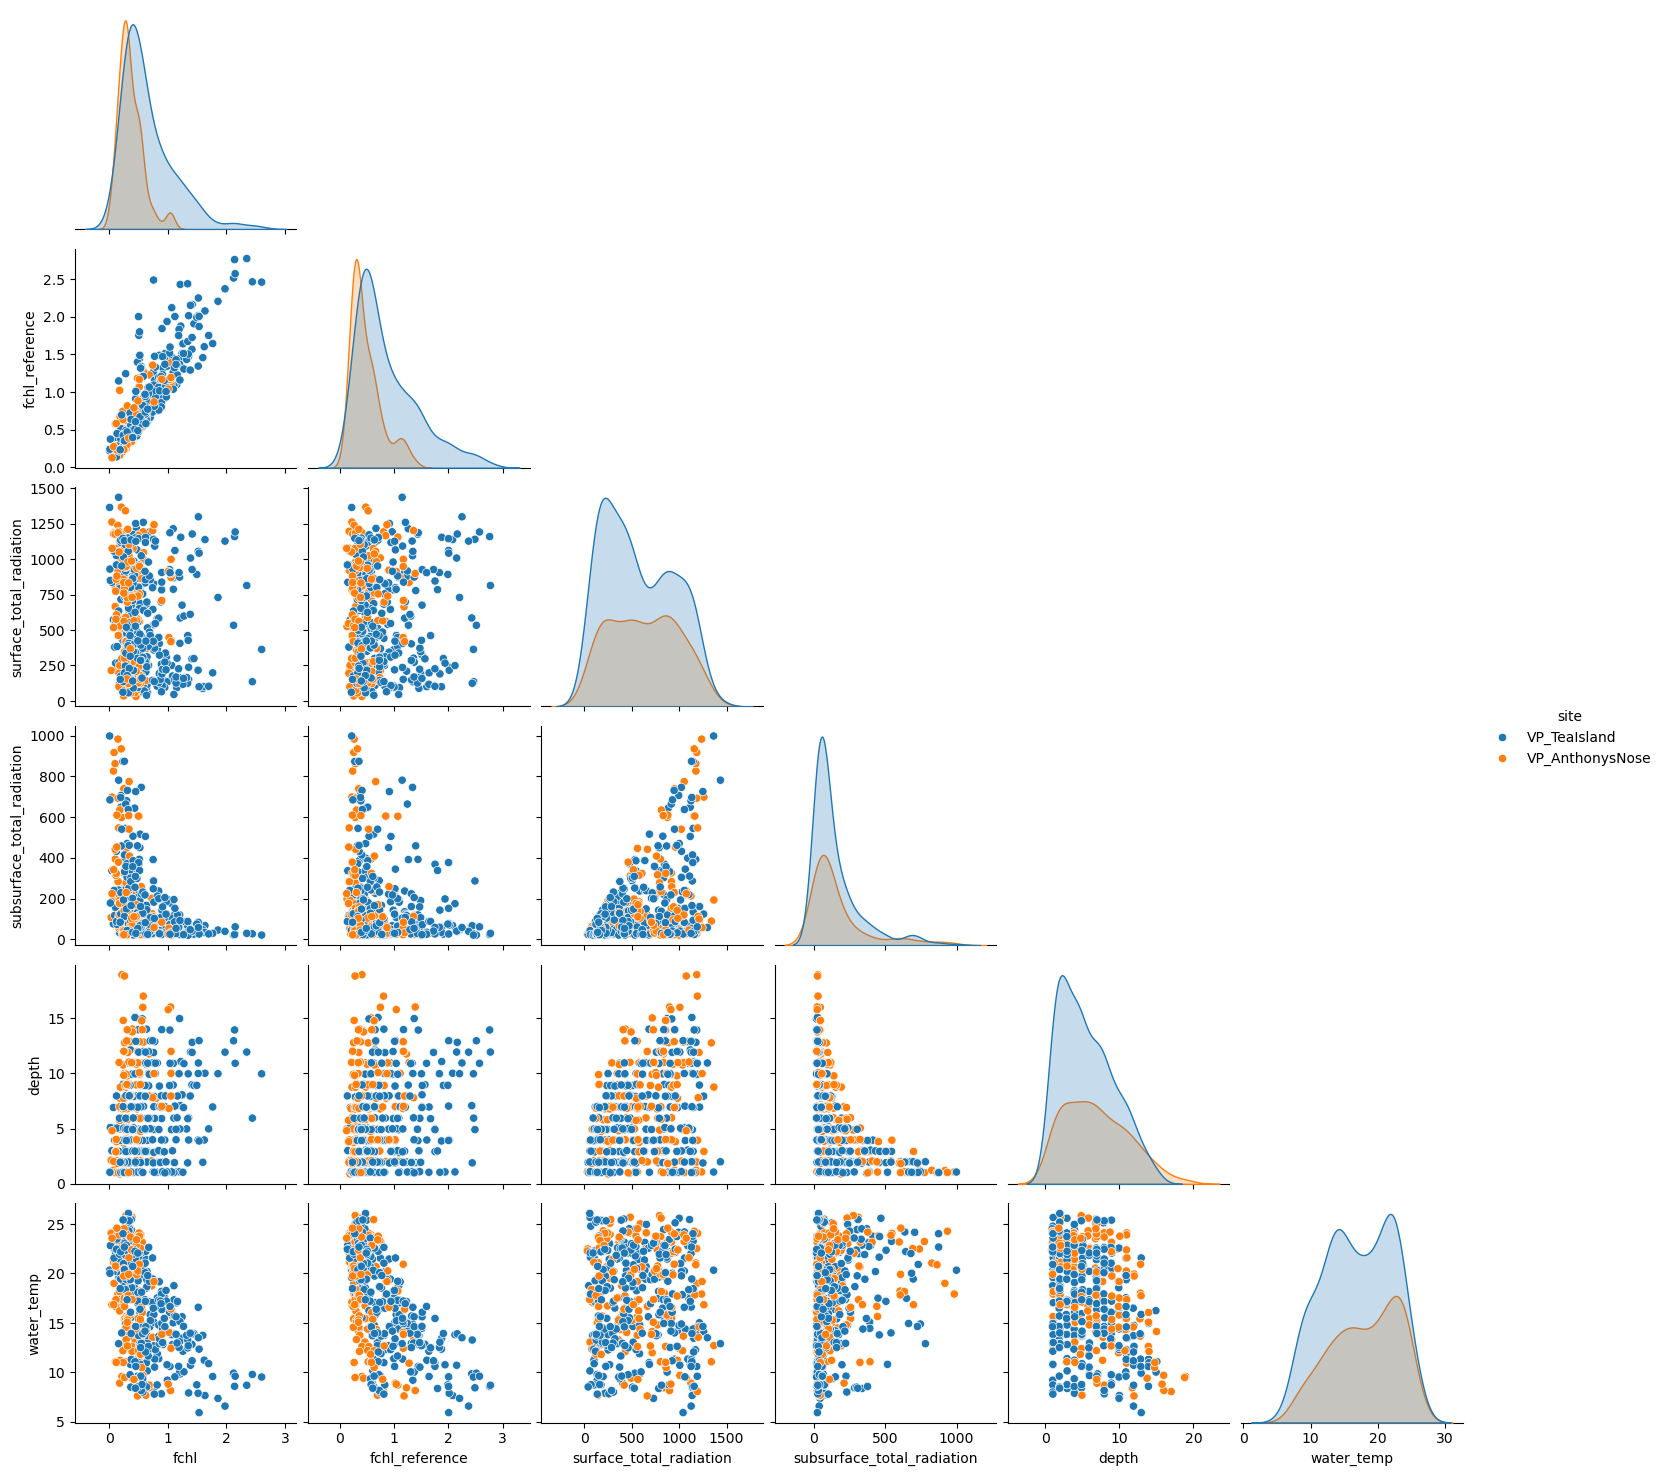

In [ ]:

sb.pairplot(lake_george_df.sample(500), 
vars=[
    'fchl', 'fchl_reference', 'surface_total_radiation', 'subsurface_total_radiation', 'depth', 'water_temp'
    ],
 diag_kind="kde", corner=True, hue='site')

### 🔍 Data Completeness relative to NPQ paper needs

* Fluorescence (Fchl, Fchl_Reference) → ✅ present.
* Irradiance (surface + subsurface, rolling mean) → ✅ present.
* Depth + water temperature → ✅ present.
* Context (site, datetime, solar azimuth, month) → ✅ present.
* No missing values → data is clean and analysis-ready.

## But hold on... What’s going on conceptually

* Sun/geometry & weather → Irradiance. Solar geometry (Solar_azimuth, time/Month) and clouds drive Surface_total_radiation, which is transformed by water optics and Depth into Subsurface_total_radiation.

* Irradiance & physiology → NPQ_state. High/light history + Water_temp (and unobserved physiology) set the NPQ_state (quenching).

* Chlorophyll & NPQ → measured fluorescence. A latent Chla_true emits fluorescence; NPQ_state suppresses yield, so the observed Fchl is Chla_true modulated by NPQ and sensor quirks.

* Reference fluorescence (Fchl_Reference) is a low-NPQ proxy (dark-adapted/algorithmic reference), i.e., closer to Chla_true than Fchl.

* DO_sat is a proxy descendant of productivity (affected by Chla_true, Irradiance, Temp, and mixing); useful for prediction, but a potential collider if used for causal identification.

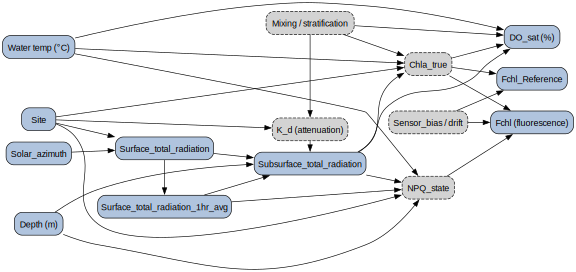

In [ ]:
# Regenerate the Graphviz DAG with latent nodes in gray and all labels in black.
def plot_dag():
    
    dot = Digraph("NPQ_DAG", format="png")
    dot.attr(rankdir="LR", bgcolor="white", size="8,10", ranksep="0.5", nodespec="0.1") 

    # Global node style: black text everywhere
    dot.attr("node", shape="rectangle", style="filled,rounded", fillcolor="lightsteelblue",
            color="black", fontname="Helvetica", fontcolor="black")

    # ---- Observed context nodes (top) ----
    observed_context = [
        ("Site", "Site"),
        ("Solar_azimuth", "Solar_azimuth"),
        ("Depth", "Depth (m)"),
        ("Water temp", "Water temp (°C)"),
    ]
    for nid, label in observed_context:
        dot.node(nid, label)

    # ---- Observed irradiance nodes ----
    irradiance_nodes = [
        ("E_surface", "Surface_total_radiation"),
        ("E_surface_avg", "Surface_total_radiation_1hr_avg"),
        ("E_subsurface", "Subsurface_total_radiation"),
    ]
    for nid, label in irradiance_nodes:
        dot.node(nid, label)

    # ---- Observed outcomes / proxies ----
    observed_outcomes = [
        ("F_chl", "Fchl (fluorescence)"),
        ("F_ref", "Fchl_Reference"),
        ("DO_sat", "DO_sat (%)"),
    ]
    for nid, label in observed_outcomes:
        dot.node(nid, label)

    # ---- Latent/unobserved nodes: dashed + gray fill ----
    dot.attr("node", style="filled,rounded,dashed", fillcolor="lightgray", fontcolor="black")
    latent_nodes = [
        ("Chla_true", "Chla_true"),
        ("NPQ_state", "NPQ_state"),
        ("K_d", "K_d (attenuation)"),
        ("Sensor_bias", "Sensor_bias / drift"),
        ("Mixing", "Mixing / stratification"),
    ]
    for nid, label in latent_nodes:
        dot.node(nid, label)

    # ---- Edges: context -> irradiance ----
    dot.edge("Solar_azimuth", "E_surface")
    dot.edge("Site", "E_surface")
    dot.edge("E_surface", "E_surface_avg")

    # Water optics to subsurface
    dot.edge("E_surface", "E_subsurface")
    dot.edge("E_surface_avg", "E_subsurface")
    dot.edge("Depth", "E_subsurface")
    dot.edge("K_d", "E_subsurface")
    dot.edge("Mixing", "K_d")
    dot.edge("Site", "K_d")

    # ---- Physiology / NPQ ----
    dot.edge("E_subsurface", "NPQ_state")
    dot.edge("E_surface_avg", "NPQ_state")     # light history
    dot.edge("Water temp", "NPQ_state")
    dot.edge("Site", "NPQ_state")
    dot.edge("Depth", "NPQ_state")

    # ---- True chl production context ----
    dot.edge("E_subsurface", "Chla_true")
    dot.edge("Water temp", "Chla_true")
    dot.edge("Site", "Chla_true")
    dot.edge("Mixing", "Chla_true")

    # ---- Measurement model ----
    dot.edge("NPQ_state", "F_chl")
    dot.edge("Chla_true", "F_chl")
    dot.edge("Sensor_bias", "F_chl")

    # Reference fluorescence (closer to true)
    dot.edge("Chla_true", "F_ref")
    dot.edge("Sensor_bias", "F_ref")

    # DO as descendant proxy of productivity & physics
    dot.edge("Chla_true", "DO_sat")
    dot.edge("E_subsurface", "DO_sat")
    dot.edge("Water temp", "DO_sat")
    dot.edge("Mixing", "DO_sat")

    # ---- Rank hints (layout) ----
    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid, _ in observed_context:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        s.node("E_surface")
        s.node("E_surface_avg")

    with dot.subgraph() as s:
        s.attr(rank="same")
        s.node("E_subsurface")
        s.node("K_d")
        s.node("Mixing")

    with dot.subgraph() as s:
        s.attr(rank="same")
        s.node("Chla_true")
        s.node("NPQ_state")

    with dot.subgraph() as s:
        s.attr(rank="same")
        s.node("F_chl")
        s.node("F_ref")
        s.node("DO_sat")
    return dot

dot = plot_dag()
dot.render("npq_dag_lake_george", cleanup=True, view=True)  # Generates PNG and source file
dot